In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import nltk
import mlflow
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

import re
import time
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from transformers import BertTokenizer, TFBertModel

import tensorflow_hub as hub

import pickle
import requests
import zipfile
import os

2024-11-05 09:18:41.089469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730798321.102557   78776 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730798321.106453   78776 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 09:18:41.120286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy
import tensorflow
import gensim
import numba
print("Numpy version:", numpy.__version__)
print("TensorFlow version:", tensorflow.__version__)
print("Gensim version:", gensim.__version__)
print("Numba version:", numba.__version__)


Numpy version: 1.26.4
TensorFlow version: 2.18.0
Gensim version: 4.3.3
Numba version: 0.60.0


In [3]:
mlflow.set_tracking_uri("http://mlflow-server:5000")

In [4]:
# Recharger le DataFrame depuis le fichier pickle
df_sample = pd.read_pickle('df_sample.pkl')
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786516 entries, 367103 to 1380859
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  786516 non-null  int64 
 1   ids     786516 non-null  int64 
 2   date    786516 non-null  object
 3   flag    786516 non-null  object
 4   user    786516 non-null  object
 5   text    786516 non-null  object
dtypes: int64(2), object(4)
memory usage: 42.0+ MB


In [5]:
 #Vérifier si le DataFrame a au moins 16 000 lignes
if len(df_sample) < 16000:
    raise ValueError("Le DataFrame contient moins de 16 000 lignes.")

# Calculer la proportion nécessaire pour obtenir 16 000 lignes
sample_size = 16000 / len(df_sample)

# Utiliser train_test_split pour sélectionner un échantillon équilibré de 16 000 lignes
df_16000, _ = train_test_split(df_sample, train_size=sample_size, stratify=df_sample['target'], random_state=42)

# Vérifier le nombre d'éléments et l'équilibre des classes
print(f"Nombre d'échantillons conservés: {len(df_16000)}")
print(df_16000['target'].value_counts(normalize=True))  # Vérifier l'équilibre des classes

df_sample = df_16000

Nombre d'échantillons conservés: 16000
target
1    0.501062
0    0.498937
Name: proportion, dtype: float64


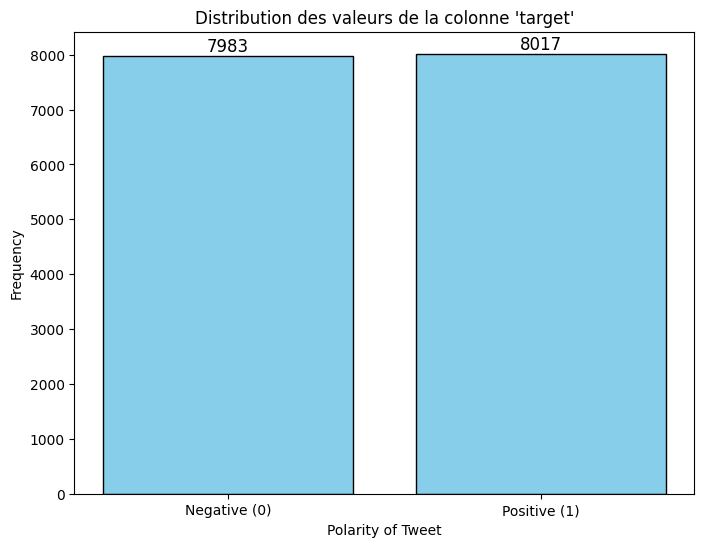

In [6]:
# Créer un histogramme des valeurs de la colonne 'target' avec des étiquettes spécifiques et le nombre total de valeurs

# Compter les occurrences de chaque valeur unique dans 'target' avec les valeurs 0, 1
target_counts = df_sample['target'].value_counts().reindex([0, 1], fill_value=0)

# Configurer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(['Negative (0)', 'Positive (1)'], target_counts, color='skyblue', edgecolor='black')

# Ajouter les annotations (le nombre total au-dessus de chaque colonne)
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom', fontsize=12)

# Personnaliser l'apparence du graphique
plt.title("Distribution des valeurs de la colonne 'target'")
plt.xlabel("Polarity of Tweet")
plt.ylabel("Frequency")
plt.show()

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Classe de prétraitement et vectorisation des tweets avec différentes méthodes
types_of_embeddings = ['w2v', 'fasttext', 'bert', 'use']

In [9]:
# Classe de prétraitement et vectorisation des tweets avec différentes méthodes
class TweetVectorizer:
    def __init__(self, vectorizer_type='w2v', method='lemmatize'):
        self.vectorizer_type = vectorizer_type
        self.method = method
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
        # Initialiser le vectorizer en fonction du type
        if vectorizer_type == 'w2v':
            self.model = None  # Placeholder pour Word2Vec qui sera entraîné explicitement
        elif vectorizer_type == 'fasttext':
            self.fasttext_model = FastText(vector_size=100, window=5, min_count=1)
        elif vectorizer_type == 'bert':
            self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
            self.model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
        elif vectorizer_type == 'use':
            self.use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        else:
            raise ValueError("vectorizer_type doit être 'w2v', 'fasttext', 'bert', ou 'use'")
    
    def clean_tweet(self, tweet):
        tweet = tweet.lower()
        tweet = re.sub(r'www\S+|http\S+', '', tweet)
        tweet = re.sub(r'@\w+', '', tweet)
        tweet = re.sub(r'#\w+', '', tweet)
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)
        tweet = re.sub(r'\s+', ' ', tweet)
        return tweet.strip()
        
    def preprocess(self, tweet):
        cleaned_tweet = self.clean_tweet(tweet)
        tokens = cleaned_tweet.split()
        
        # Appliquer le stemming ou la lemmatisation
        if self.method == 'stem':
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.method == 'lemmatize':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    # Méthode `fit_transform` mise à jour dans TweetVectorizer pour vérifier et ajuster la forme
    def fit_transform(self, documents):
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.fasttext_model.build_vocab(tokenized_docs)
            self.fasttext_model.train(tokenized_docs, total_examples=len(tokenized_docs), epochs=10)
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            X = self._bert_vectorize(documents_preprocessed)
        elif self.vectorizer_type == 'use':
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
        
        # Assurer que X est bien en 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim == 2 and X.shape[1] == 1:
            # S'assurer que la deuxième dimension correspond bien à l'embedding dimension
            X = X.reshape(-1, X.shape[1])
        
        return X

    def transform(self, documents):
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            X = self._bert_vectorize(documents_preprocessed)
        elif self.vectorizer_type == 'use':
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
    
        # Assurer que X est bien en 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim == 2 and X.shape[1] == 1:
            X = X.reshape(-1, X.shape[1])
        
        return X

    def _bert_vectorize(self, documents):
        batch_size = 16  # Réduction de la taille du batch pour éviter les erreurs OOM
        batches = [documents[i:i + batch_size] for i in range(0, len(documents), batch_size)]
        
        outputs_list = []
        for batch in batches:
            tokenized_inputs = self.tokenizer(batch, return_tensors='tf', padding=True, truncation=True, max_length=32)
            outputs = self.model(tokenized_inputs).logits
            outputs_list.append(tf.reduce_mean(outputs, axis=1).numpy())
        
        return np.concatenate(outputs_list, axis=0)

In [10]:
# Classe pour la classification avec régression logistique
class TweetClassifier:
    def __init__(self):
        self.model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        # Suivi de l'entraînement du modèle dans MLflow comme sous-exécution
        with mlflow.start_run(run_name="Classification", nested=True):
            mlflow.set_tag("Stage", "Classification")
            mlflow.set_tag("model", "Logistic Regression")
            
            # Enregistrer les hyperparamètres du modèle
            mlflow.log_param("C", self.model.get_params()['C'])
            mlflow.log_param("solver", self.model.get_params()['solver'])
            mlflow.log_param("penalty", self.model.get_params()['penalty'])
            
            # Entraîner le modèle avec Cross-Validation sur le set d'entraînement
            cross_val_scores = cross_val_score(self.model, X_train, y_train, cv=5, scoring='accuracy')
            mlflow.log_metric("cross_val_accuracy_mean", cross_val_scores.mean())
            mlflow.log_metric("cross_val_accuracy_std", cross_val_scores.std())

            # Entraîner sur l'ensemble d'entraînement complet
            start_time = time.time()
            self.model.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("training_time_seconds", training_time)
            
            # Évaluation sur l'ensemble de validation
            y_val_pred = self.model.predict(X_val)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            mlflow.log_metric("validation_accuracy", val_accuracy)
            mlflow.log_text(classification_report(y_val, y_val_pred), "validation_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de validation
            y_val_prob = self.model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            roc_auc_val = auc(fpr, tpr)
            mlflow.log_metric("validation_roc_auc", roc_auc_val)

            # Tracer et enregistrer la courbe ROC
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            plt.savefig("roc_curve_val.png")
            mlflow.log_artifact("roc_curve_val.png")
            plt.close()
            
            print(f"Validation Accuracy : {val_accuracy}")
            print(classification_report(y_val, y_val_pred))
    
    def final_evaluation(self, X_test, y_test):
        # Évaluation finale sur le set de test
        with mlflow.start_run(run_name="Final Test Evaluation", nested=True):
            mlflow.set_tag("Stage", "Final Test Evaluation")
            y_test_pred = self.model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            mlflow.log_metric("test_accuracy", test_accuracy)
            mlflow.log_text(classification_report(y_test, y_test_pred), "test_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de test
            y_test_prob = self.model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            roc_auc_test = auc(fpr, tpr)
            mlflow.log_metric("test_roc_auc", roc_auc_test)

            # Tracer et enregistrer la courbe ROC pour le set de test
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_test:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Test Set")
            plt.legend(loc="lower right")
            plt.savefig("roc_curve_test.png")
            mlflow.log_artifact("roc_curve_test.png")
            plt.close()
            
            # Enregistrer le modèle final
            mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            
            print(f"Test Accuracy : {test_accuracy}")
            print(classification_report(y_test, y_test_pred))


In [11]:
# Définition des combinaisons à tester
configurations = [
    {'vectorizer_type': 'w2v', 'method': 'lemmatize'},
    {'vectorizer_type': 'w2v', 'method': 'stem'},
    {'vectorizer_type': 'fasttext', 'method': 'lemmatize'},
    {'vectorizer_type': 'fasttext', 'method': 'stem'},
    {'vectorizer_type': 'bert', 'method': 'lemmatize'},
    {'vectorizer_type': 'bert', 'method': 'stem'},
    {'vectorizer_type': 'use', 'method': 'lemmatize'},
    {'vectorizer_type': 'use', 'method': 'stem'}
]

In [12]:
# Séparer les données en Train, Validation et Test une seule fois
# Utiliser les tweets originaux pour diviser les ensembles de manière cohérente
y = df_sample['target']
tweets = df_sample['text']
y_train_val, y_test = train_test_split(y, test_size=0.2, random_state=42)
tweets_train_val, tweets_test = train_test_split(tweets, test_size=0.2, random_state=42)

# Rediviser l'ensemble Train + Validation en Train et Validation
y_train, y_val = train_test_split(y_train_val, test_size=0.25, random_state=42)
tweets_train, tweets_val = train_test_split(tweets_train_val, test_size=0.25, random_state=42)

# Boucle pour tester chaque configuration
for config in configurations:
    # Démarrer une nouvelle exécution parent pour chaque configuration
    with mlflow.start_run(run_name=f"{config['vectorizer_type']} + {config['method']}", nested=False):
        print(f"Testing configuration: {config}")
        
        # Enregistrer les paramètres de configuration comme tags
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        
        # Initialiser et appliquer la vectorisation avec TweetVectorizer
        tweet_vectorizer = TweetVectorizer(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Vectorisation des ensembles Train, Validation et Test
        X_train = tweet_vectorizer.fit_transform(tweets_train)
        X_val = tweet_vectorizer.transform(tweets_val)
        X_test = tweet_vectorizer.transform(tweets_test)
        
        # Initialiser le classificateur
        classifier = TweetClassifier()
        
        # Entraîner et évaluer le modèle avec Train et Validation
        classifier.train_and_evaluate(X_train, X_val, y_train, y_val)

        # Évaluation finale sur le set de Test
        classifier.final_evaluation(X_test, y_test)

Testing configuration: {'vectorizer_type': 'w2v', 'method': 'lemmatize'}


2024/11/05 09:18:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/c8a7a7ecb4fb459ebdf21b02760a3e72.
2024/11/05 09:18:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.610625
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      1637
           1       0.59      0.65      0.62      1563

    accuracy                           0.61      3200
   macro avg       0.61      0.61      0.61      3200
weighted avg       0.61      0.61      0.61      3200



2024/11/05 09:18:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:18:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/d317dc077d30411db3065d109bea09a2.
2024/11/05 09:18:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:18:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run w2v + lemmatize at: http://mlflow-server:5000/#/experiments/0/runs/7ffb45c3d62d45718b696ccea1f727ac.
2024/11/05 09:18:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.609375
              precision    recall  f1-score   support

           0       0.62      0.57      0.59      1611
           1       0.60      0.65      0.62      1589

    accuracy                           0.61      3200
   macro avg       0.61      0.61      0.61      3200
weighted avg       0.61      0.61      0.61      3200

Testing configuration: {'vectorizer_type': 'w2v', 'method': 'stem'}


2024/11/05 09:18:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/55ded85df61c4a1cae27229550a6195c.
2024/11/05 09:18:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.61625
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1637
           1       0.60      0.66      0.63      1563

    accuracy                           0.62      3200
   macro avg       0.62      0.62      0.62      3200
weighted avg       0.62      0.62      0.62      3200



2024/11/05 09:18:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:18:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/7c2a2041ee734302b4ee91d6ae97117c.
2024/11/05 09:18:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:18:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run w2v + stem at: http://mlflow-server:5000/#/experiments/0/runs/0a2b0fe53e134c07a9e38a79036a4d7d.
2024/11/05 09:18:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.6075
              precision    recall  f1-score   support

           0       0.62      0.56      0.59      1611
           1       0.59      0.66      0.62      1589

    accuracy                           0.61      3200
   macro avg       0.61      0.61      0.61      3200
weighted avg       0.61      0.61      0.61      3200

Testing configuration: {'vectorizer_type': 'fasttext', 'method': 'lemmatize'}


/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Validation Accuracy : 0.643125
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1637
           1       0.63      0.66      0.64      1563

    accuracy                           0.64      3200
   macro avg       0.64      0.64      0.64      3200
weighted avg       0.64      0.64      0.64      3200



2024/11/05 09:19:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:19:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/08082999aa75415f8e26eeb3d4b2f49e.
2024/11/05 09:19:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:19:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run fasttext + lemmatize at: http://mlflow-server:5000/#/experiments/0/runs/45ea4b4adfa94da385b0d3ed0f5825e0.
2024/11/05 09:19:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.6303125
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      1611
           1       0.62      0.65      0.63      1589

    accuracy                           0.63      3200
   macro avg       0.63      0.63      0.63      3200
weighted avg       0.63      0.63      0.63      3200

Testing configuration: {'vectorizer_type': 'fasttext', 'method': 'stem'}


/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Validation Accuracy : 0.64125
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      1637
           1       0.63      0.65      0.64      1563

    accuracy                           0.64      3200
   macro avg       0.64      0.64      0.64      3200
weighted avg       0.64      0.64      0.64      3200



2024/11/05 09:19:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:19:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/74f8322ea56a463bac83375f9235f388.
2024/11/05 09:19:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:19:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run fasttext + stem at: http://mlflow-server:5000/#/experiments/0/runs/960600531c3645c59689e0912059ebdd.
2024/11/05 09:19:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.6359375
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1611
           1       0.63      0.65      0.64      1589

    accuracy                           0.64      3200
   macro avg       0.64      0.64      0.64      3200
weighted avg       0.64      0.64      0.64      3200

Testing configuration: {'vectorizer_type': 'bert', 'method': 'lemmatize'}


2024-11-05 09:19:09.265155: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024/11/05 09:26:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/d6040dfc64e94fc79b865f8cfe9b5f41.
2024/11/05 09:26:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.5065625
              precision    recall  f1-score   support

           0       0.53      0.31      0.39      1637
           1       0.50      0.71      0.59      1563

    accuracy                           0.51      3200
   macro avg       0.51      0.51      0.49      3200
weighted avg       0.51      0.51      0.49      3200



2024/11/05 09:26:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:26:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/7bd2fb67c9674e4f8228d03310b8e0ae.
2024/11/05 09:26:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:26:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run bert + lemmatize at: http://mlflow-server:5000/#/experiments/0/runs/88637234561242839c2c383d97827ea6.
2024/11/05 09:26:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.5090625
              precision    recall  f1-score   support

           0       0.52      0.30      0.38      1611
           1       0.50      0.72      0.59      1589

    accuracy                           0.51      3200
   macro avg       0.51      0.51      0.49      3200
weighted avg       0.51      0.51      0.49      3200

Testing configuration: {'vectorizer_type': 'bert', 'method': 'stem'}


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024/11/05 09:34:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/c033b4bb752f45918599adc2b952e816.
2024/11/05 09:34:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.5025
              precision    recall  f1-score   support

           0       0.52      0.37      0.43      1637
           1       0.49      0.65      0.56      1563

    accuracy                           0.50      3200
   macro avg       0.51      0.51      0.49      3200
weighted avg       0.51      0.50      0.49      3200



2024/11/05 09:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:34:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/080a8e76c79e4c808181370d9cb686ed.
2024/11/05 09:34:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:34:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run bert + stem at: http://mlflow-server:5000/#/experiments/0/runs/e80f200a822f45faa90f26d01624df7d.
2024/11/05 09:34:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.4996875
              precision    recall  f1-score   support

           0       0.50      0.38      0.43      1611
           1       0.50      0.62      0.55      1589

    accuracy                           0.50      3200
   macro avg       0.50      0.50      0.49      3200
weighted avg       0.50      0.50      0.49      3200

Testing configuration: {'vectorizer_type': 'use', 'method': 'lemmatize'}


2024/11/05 09:34:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/cd5fc205f3954dd88fb729a82e657c26.
2024/11/05 09:34:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.77125
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1637
           1       0.76      0.77      0.77      1563

    accuracy                           0.77      3200
   macro avg       0.77      0.77      0.77      3200
weighted avg       0.77      0.77      0.77      3200



2024/11/05 09:34:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:34:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/8c73c5633a074740aa0c5cc2cb47765a.
2024/11/05 09:34:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:34:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run use + lemmatize at: http://mlflow-server:5000/#/experiments/0/runs/a7ed952ade9845ae88f825c6611fc7f1.
2024/11/05 09:34:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.775
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1611
           1       0.77      0.77      0.77      1589

    accuracy                           0.78      3200
   macro avg       0.77      0.77      0.77      3200
weighted avg       0.77      0.78      0.77      3200

Testing configuration: {'vectorizer_type': 'use', 'method': 'stem'}


2024/11/05 09:34:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/0/runs/edbd700fcab34949b98517fc3be2fdad.
2024/11/05 09:34:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Validation Accuracy : 0.750625
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1637
           1       0.75      0.74      0.74      1563

    accuracy                           0.75      3200
   macro avg       0.75      0.75      0.75      3200
weighted avg       0.75      0.75      0.75      3200



2024/11/05 09:34:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 09:34:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/0/runs/eaa75ef7460c4130beeb651d672a86bb.
2024/11/05 09:34:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.
2024/11/05 09:34:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run use + stem at: http://mlflow-server:5000/#/experiments/0/runs/5b1f0e71557247b9a6a0c7e13d72a3c6.
2024/11/05 09:34:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Test Accuracy : 0.75125
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1611
           1       0.75      0.74      0.75      1589

    accuracy                           0.75      3200
   macro avg       0.75      0.75      0.75      3200
weighted avg       0.75      0.75      0.75      3200



In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional  # Ajout de Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, FastText

In [21]:
class LSTMTweetClassifier:
    def __init__(self, embedding_type='w2v', embedding_dim=100, max_length=100):
        self.embedding_type = embedding_type
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.tokenizer = Tokenizer()
        self.model = None
        self.stop_words = set(stopwords.words('english'))

    def clean_tweet(self, tweet):
        """Nettoie le texte du tweet en supprimant les liens, mentions, hashtags et caractères spéciaux."""
        tweet = tweet.lower()
        tweet = re.sub(r'www\S+|http\S+', '', tweet)  # Supprime les liens
        tweet = re.sub(r'@\w+', '', tweet)            # Supprime les mentions
        tweet = re.sub(r'#\w+', '', tweet)            # Supprime les hashtags
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)    # Supprime les caractères spéciaux
        tweet = re.sub(r'\s+', ' ', tweet)            # Remplace les multiples espaces par un seul espace
        return tweet.strip()

    def preprocess_and_tokenize(self, documents):
        # Nettoyage et suppression des stopwords
        cleaned_docs = []
        for doc in documents:
            cleaned_doc = self.clean_tweet(doc)
            # Supprimer les stopwords après le nettoyage
            words = cleaned_doc.split()
            filtered_words = [word for word in words if word not in self.stop_words]
            cleaned_docs.append(' '.join(filtered_words))
        
        # Convertir les documents nettoyés en tokens
        self.tokenizer.fit_on_texts(cleaned_docs)
        sequences = self.tokenizer.texts_to_sequences(cleaned_docs)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post')
        return padded_sequences

    def build_embedding_matrix(self, documents):
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))
        
        # Préparation des phrases pour l'entraînement d'embeddings
        sentences = [self.clean_tweet(doc).split() for doc in documents]
        
        if self.embedding_type == 'w2v':
            model = Word2Vec(sentences=sentences, vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
        elif self.embedding_type == 'fasttext':
            model = FastText(sentences=sentences, vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
        else:
            raise ValueError("embedding_type must be 'w2v' or 'fasttext'")
        
        for word, i in word_index.items():
            if word in model.wv:
                embedding_matrix[i] = model.wv[word]
        
        return embedding_matrix

    def build_model(self, vocab_size, embedding_matrix):
        self.model = Sequential()
        self.model.add(Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, 
                                 weights=[embedding_matrix], input_length=self.max_length, trainable=False))
        self.model.add(Bidirectional(LSTM(128, return_sequences=False)))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        if self.model is None:
            raise RuntimeError("Model has not been built. Call build_model() before training.")
        
        with mlflow.start_run():
            # Enregistrement des hyperparamètres
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("embedding_type", self.embedding_type)
            
            # Entraînement du modèle
            history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
            
            # Enregistrement des métriques
            for epoch, acc in enumerate(history.history['accuracy']):
                mlflow.log_metric("train_accuracy", acc, step=epoch)
            for epoch, val_acc in enumerate(history.history['val_accuracy']):
                mlflow.log_metric("val_accuracy", val_acc, step=epoch)
            
            # Enregistrement du modèle
            mlflow.keras.log_model(self.model, "model")

    def fit(self, documents, labels, val_split=0.2, epochs=10, batch_size=32):
        # Prétraitement et tokenisation
        padded_sequences = self.preprocess_and_tokenize(documents)
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_matrix = self.build_embedding_matrix(documents)
        
        # Construction du modèle LSTM avec embedding Word2Vec ou FastText
        self.build_model(vocab_size, embedding_matrix)
        
        # Division en ensembles d'entraînement et de validation
        split_index = int(len(padded_sequences) * (1 - val_split))
        X_train, X_val = padded_sequences[:split_index], padded_sequences[split_index:]
        y_train, y_val = labels[:split_index], labels[split_index:]
        
        # Entraînement et évaluation
        self.train_and_evaluate(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

    def predict(self, documents):
        padded_sequences = self.preprocess_and_tokenize(documents)
        predictions = self.model.predict(padded_sequences)
        return (predictions > 0.5).astype(int).flatten()

In [22]:
# Définition des combinaisons à tester
configurations = [
    {
        "embedding_type": "w2v",
        "embedding_dim": 50,
        "lstm_units": 64,
        "epochs": 5,
        "batch_size": 32
    },
    {
        "embedding_type": "w2v",
        "embedding_dim": 100,
        "lstm_units": 128,
        "epochs": 10,
        "batch_size": 32
    },
    {
        "embedding_type": "fasttext",
        "embedding_dim": 50,
        "lstm_units": 64,
        "epochs": 5,
        "batch_size": 32
    },
    {
        "embedding_type": "fasttext",
        "embedding_dim": 100,
        "lstm_units": 128,
        "epochs": 10,
        "batch_size": 32
    },
    # Vous pouvez ajouter d'autres configurations ici
]


In [23]:
documents = df_sample['text']
labels = df_sample['target']

# Boucle sur chaque configuration pour tester
for config in configurations:
    print(f"Testing configuration: {config}")
    model = LSTMTweetClassifier(
        embedding_type=config["embedding_type"],
        embedding_dim=config["embedding_dim"],
        max_length=100  # Vous pouvez ajuster cette valeur si nécessaire
    )
    
    # # Préparation des données d'entraînement et de validation
    # documents = [...]  # Remplacez par votre liste de tweets
    # labels = [...]     # Remplacez par votre liste de labels (0 ou 1)
    
    # Entraînement du modèle avec la configuration actuelle
    model.fit(
        documents, 
        labels, 
        epochs=config["epochs"], 
        batch_size=config["batch_size"]
    )
    
    # Ici, vous pouvez ajouter des étapes pour enregistrer ou comparer les résultats, par exemple :
    # - Enregistrer les métriques dans un dictionnaire ou un fichier pour une analyse ultérieure
    # - Comparer les résultats dans MLFlow
    print(f"Finished testing configuration: {config}")

Testing configuration: {'embedding_type': 'w2v', 'embedding_dim': 50, 'lstm_units': 64, 'epochs': 5, 'batch_size': 32}
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.5525 - loss: 0.6840 - val_accuracy: 0.5975 - val_loss: 0.6856
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5827 - loss: 0.6735 - val_accuracy: 0.6081 - val_loss: 0.6639
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6106 - loss: 0.6599 - val_accuracy: 0.6031 - val_loss: 0.6626
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.6157 - loss: 0.6533 - val_accuracy: 0.5919 - val_loss: 0.6693
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.6234 - loss: 0.6470 - val_accuracy: 0.6019 - val_loss: 0.6629


2024/11/05 10:18:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/05 10:18:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 10:18:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-mink-456 at: http://mlflow-server:5000/#/experiments/0/runs/8957a71f7be34b4280ea0caec90c6d78.
2024/11/05 10:18:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Finished testing configuration: {'embedding_type': 'w2v', 'embedding_dim': 50, 'lstm_units': 64, 'epochs': 5, 'batch_size': 32}
Testing configuration: {'embedding_type': 'w2v', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.5496 - loss: 0.6837 - val_accuracy: 0.5938 - val_loss: 0.6717
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5902 - loss: 0.6686 - val_accuracy: 0.6025 - val_loss: 0.6608
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6062 - loss: 0.6578 - val_accuracy: 0.5922 - val_loss: 0.6613
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.6146 - loss: 0.6509 - val_accuracy: 0.6125 - val_loss: 0.6584
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.6171 - loss: 0.6500 - val_accuracy: 0.6269 - val_loss: 0.6387
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.6260 - loss: 0.6388 - val_accura

2024/11/05 10:21:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/05 10:21:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 10:21:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-chimp-363 at: http://mlflow-server:5000/#/experiments/0/runs/311fa0d200d949f79050e2a43e3bc11f.
2024/11/05 10:21:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Finished testing configuration: {'embedding_type': 'w2v', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32}
Testing configuration: {'embedding_type': 'fasttext', 'embedding_dim': 50, 'lstm_units': 64, 'epochs': 5, 'batch_size': 32}
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.5259 - loss: 0.6911 - val_accuracy: 0.5288 - val_loss: 0.6917
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.5709 - loss: 0.6789 - val_accuracy: 0.5719 - val_loss: 0.6770
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.5662 - loss: 0.6787 - val_accuracy: 0.5966 - val_loss: 0.6699
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.5867 - loss: 0.6721 - val_accuracy: 0.6078 - val_loss: 0.6657
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.5859 - loss: 0.6692 - val_accuracy: 0.5844 - val_loss: 0.6679


2024/11/05 10:23:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/05 10:23:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 10:23:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run unruly-fowl-230 at: http://mlflow-server:5000/#/experiments/0/runs/bd64d64e0ef54438b0f504a2fca5771f.
2024/11/05 10:23:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Finished testing configuration: {'embedding_type': 'fasttext', 'embedding_dim': 50, 'lstm_units': 64, 'epochs': 5, 'batch_size': 32}
Testing configuration: {'embedding_type': 'fasttext', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.5333 - loss: 0.6913 - val_accuracy: 0.5478 - val_loss: 0.6892
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.5703 - loss: 0.6785 - val_accuracy: 0.5612 - val_loss: 0.6826
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.5677 - loss: 0.6762 - val_accuracy: 0.5866 - val_loss: 0.6722
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.5809 - loss: 0.6725 - val_accuracy: 0.5875 - val_loss: 0.6697
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.5906 - loss: 0.6691 - val_accuracy: 0.5909 - val_loss: 0.6670
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.5934 - loss: 0.6655 - 

2024/11/05 10:27:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/05 10:27:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/05 10:27:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-dolphin-898 at: http://mlflow-server:5000/#/experiments/0/runs/1a3f4732bed34232837be43df21f725c.
2024/11/05 10:27:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/0.


Finished testing configuration: {'embedding_type': 'fasttext', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32}


In [35]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from nltk.corpus import stopwords
import re

class SimpleBERTTrainer:
    def __init__(self, model_name='bert-base-uncased', max_length=128, learning_rate=2e-5):
        self.model_name = model_name
        self.max_length = max_length
        self.learning_rate = learning_rate
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        self.stop_words = set(stopwords.words('english'))

    def clean_tweet(self, tweet):
        tweet = tweet.lower()
        tweet = re.sub(r'www\S+|http\S+', '', tweet)  # Supprime les liens
        tweet = re.sub(r'@\w+', '', tweet)            # Supprime les mentions
        tweet = re.sub(r'#\w+', '', tweet)            # Supprime les hashtags
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)    # Supprime les caractères spéciaux
        tweet = re.sub(r'\s+', ' ', tweet)            # Remplace les multiples espaces par un seul espace
        return tweet.strip()

    def preprocess(self, documents):
        input_ids = []
        attention_masks = []
        
        for doc in documents:
            # Nettoyage et suppression des stopwords
            cleaned_doc = self.clean_tweet(doc)
            words = cleaned_doc.split()
            filtered_words = [word for word in words if word not in self.stop_words]
            cleaned_text = ' '.join(filtered_words)
            
            # Encodage du texte nettoyé
            encoded = self.tokenizer.encode_plus(
                cleaned_text,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                return_attention_mask=True,
                truncation=True
            )
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
        
        input_ids = np.array(input_ids)
        attention_masks = np.array(attention_masks)
        return input_ids, attention_masks



    def train(self, documents, labels, test_size=0.8, epochs=3, batch_size=16):
        # Assurez-vous que labels est de type int32
        labels = np.array(labels, dtype=np.int32)
        
        # Prétraitement des données
        input_ids, attention_masks = self.preprocess(documents)
        
        # Division des données en ensemble d'entraînement et de validation
        X_train_ids, X_val_ids, X_train_masks, X_val_masks, y_train, y_val = train_test_split(
            input_ids, attention_masks, labels, test_size=test_size, random_state=42
        )
        
        # Compilation du modèle avec une fonction de perte explicite
        loss_fn = SparseCategoricalCrossentropy(from_logits=True)
        self.model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
        
        # Entraînement du modèle sans Early Stopping
        history = self.model.fit(
            [X_train_ids, X_train_masks], y_train,
            validation_data=([X_val_ids, X_val_masks], y_val),
            epochs=epochs,
            batch_size=batch_size
        )
        
        # Affichage des résultats d'entraînement et de validation
        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")



# Utilisation de la classe SimpleBERTTrainer pour entraîner et évaluer BERT
# documents = [...]  # Remplacez par la liste de tweets
# labels = [...]     # Remplacez par la liste des labels (0 ou 1)
documents = df_sample['text']
labels = df_sample['target']

# Initialisation et entraînement du modèle
bert_trainer = SimpleBERTTrainer()
bert_trainer.train(documents, labels, epochs=3, batch_size=16)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/3
200/200 [==============================] - 1812s 9s/step - loss: 0.7233 - accuracy: 0.5113 - val_loss: 0.7004 - val_accuracy: 0.4952
Epoch 2/3
200/200 [==============================] - 1715s 9s/step - loss: 0.7146 - accuracy: 0.4988 - val_loss: 0.6943 - val_accuracy: 0.5048
Epoch 3/3
200/200 [==============================] - 1688s 8s/step - loss: 0.7063 - accuracy: 0.5063 - val_loss: 0.7175 - val_accuracy: 0.4952
Train Accuracy: 0.5063
Validation Accuracy: 0.4952


In [ ]:
pip install transformers==4.10.0

